In [1]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score


# Step 1: Data Preprocessing

In [5]:
# Define your target dataset path
target_dir = '../balanced_dataset'

# Check if the path exists
if os.path.exists(target_dir):
    print(f"The dataset path {target_dir} exists.")
else:
    print(f"The dataset path {target_dir} does not exist.")

The dataset path ../balanced_dataset exists.


In [6]:
classes = ['home_office', 'hotel_room', 'church', 'museum', 'supermarket']

def show_target_dir_status(target_dir, classes):
    """
    Show the number of images in each class directory within the target directory.

    """
    print(f"Status of target directory: {target_dir}")
    for cls in classes:
        class_dir = os.path.join(target_dir, cls)
        if os.path.exists(class_dir):
            num_images = len(os.listdir(class_dir))
            print(f"Class '{cls}' contains {num_images} images.")
        else:
            print(f"Class directory '{cls}' does not exist.")

# Show the status of the target directory
show_target_dir_status(target_dir, classes)

Status of target directory: ../balanced_dataset
Class 'home_office' contains 700 images.
Class 'hotel_room' contains 700 images.
Class 'church' contains 700 images.
Class 'museum' contains 700 images.
Class 'supermarket' contains 700 images.


In [8]:
# Set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Parameters
batch_size = 32
image_size = (256, 256)

# Transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.ImageFolder(root='../balanced_dataset', transform=transform)

# Split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 2: Define the CNN Model

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, len(dataset.classes))
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # Define the forward pass
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model and move it to the device
model = CNN().to(device)

# Step 3: Training the Model

In [10]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 10

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

# Validation function
def validate(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(test_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    return epoch_loss, accuracy

# Training loop
best_accuracy = 0.0
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model

print(f"Best Validation Accuracy: {best_accuracy:.4f}")


Epoch 1/10, Train Loss: 1.5267, Validation Loss: 1.1922, Validation Accuracy: 0.5086
Epoch 2/10, Train Loss: 1.1492, Validation Loss: 1.0259, Validation Accuracy: 0.5986
Epoch 3/10, Train Loss: 0.9844, Validation Loss: 1.0321, Validation Accuracy: 0.5943
Epoch 4/10, Train Loss: 0.8246, Validation Loss: 1.0304, Validation Accuracy: 0.6029
Epoch 5/10, Train Loss: 0.6658, Validation Loss: 1.2286, Validation Accuracy: 0.5914
Epoch 6/10, Train Loss: 0.4357, Validation Loss: 1.3927, Validation Accuracy: 0.5957
Epoch 7/10, Train Loss: 0.2312, Validation Loss: 1.6310, Validation Accuracy: 0.5843
Epoch 8/10, Train Loss: 0.1380, Validation Loss: 1.8558, Validation Accuracy: 0.5729
Epoch 9/10, Train Loss: 0.1033, Validation Loss: 2.4333, Validation Accuracy: 0.5629
Epoch 10/10, Train Loss: 0.0514, Validation Loss: 2.5169, Validation Accuracy: 0.5671
Best Validation Accuracy: 0.6029


# Step 4: Loading the Model and Making Predictions

In [12]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

# Function to predict on the test set
def predict(model, test_loader, device):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
    return all_preds

# Predict on the test set
test_preds = predict(model, test_loader, device)

# Function to predict on a single image
def predict_single_image(model, image_path, transform, device):
    model.eval()
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).cpu().numpy()[0]
    return dataset.classes[pred]

# Predict on a single image
image_path = '../balanced_dataset/church/gsun_0a4d8276a4ea8abc5dc0554157b09fb2.jpg'
single_pred = predict_single_image(model, image_path, transform, device)
print(f"Predicted class: {single_pred}")


Predicted class: church


# Confusion Matrix

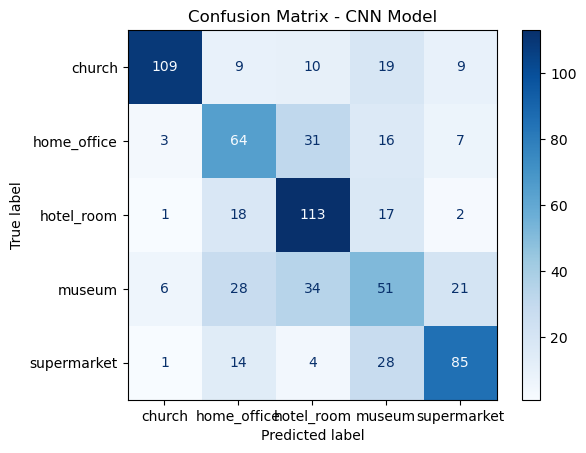

In [13]:
# Generate confusion matrix
y_test_labels = [label for _, label in test_dataset]
cm = confusion_matrix(y_test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - CNN Model")
plt.show()

# Evaluate the model

In [15]:
accuracy = accuracy_score(y_test_labels, test_preds)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test_labels, test_preds, target_names=classes))

Accuracy: 0.6028571428571429
Classification Report:
               precision    recall  f1-score   support

 home_office       0.91      0.70      0.79       156
  hotel_room       0.48      0.53      0.50       121
      church       0.59      0.75      0.66       151
      museum       0.39      0.36      0.38       140
 supermarket       0.69      0.64      0.66       132

    accuracy                           0.60       700
   macro avg       0.61      0.60      0.60       700
weighted avg       0.62      0.60      0.61       700

